<a href="https://colab.research.google.com/github/havfanridindis/Tomb-Raider-Meets-Computer-Science/blob/main/The_4_pillar_puzzle.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Overview

This is a computer-scientific analysis of the four-pillar puzzle at the beginning of the chapter "Sanctuary of the Scion" in Tomb Raider Anniversary. Here we're not just solving the initial state encountered in the game, we're going above and beyond to answer these very pressing questions:

How many different ways can we solve the puzzle? How many initial states can the puzzle have? How many unique moves could you perform? Is it always solvable no matter the initial state? If yes, can we come up with a strategy to always solve it? How many moves would you need at most to solve any state? Which state requires the most moves to solve? What is the distribution of the number of moves required per state?

# The puzzle

When you enter the room, you see four pillars (each with four images) forming a square. They are oriented so that the matching pictures on all pillars are facing the same direction (i.e. on all four pillars, the picture of the person holding a round pot faces the entrance). The idea is to rotate the pillars so the pictures facing each other along each side of the square match. Sounds simple enough except that turning one pillar also causes the two adjacent pillars to turn.

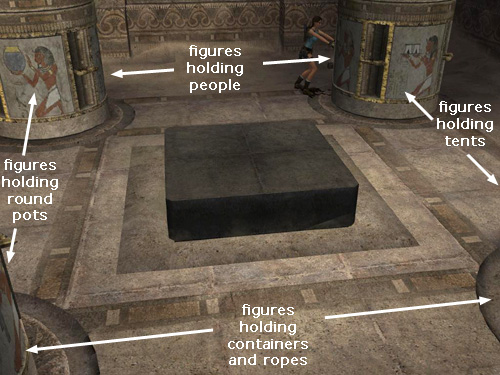

In [ ]:
'''from IPython.display import Image, display
display(Image('puzzle_room.jpg'))'''

# Creating a custom state for our puzzle


 A puzzle state consists of a list of 4 pillars, numbered clockwise from the top left corner of the square:

\begin{bmatrix}
    \text{1s pillar} & \text{2nd pillar} \\
    \text{4th pillar} & \text{3rd pillar} \\
\end{bmatrix}

 Each pillar is represented by an integer between 0 and 3 indicating the current way the pillar is facing. An example state would be `[3,1,2,2]`, indicating that looking from the entrance, you see picture number 3 on the 1st pillar, picture number 1 on the 2nd pillar and picture number 2 on the 3rd and 4th pillars.  Due to symmetry, it doesn't really matter which picture you number 0. For this analysis, we'll label picture 0 the person holding a round pot and continue clockwise so that the initial state encountered in the game is `[0,0,0,0]`.

 Rotating any pillar will cause the adjacent ones to rotate as well in the same direction. For example, rotating the 2nd pillar of state `[3,1,2,2]` clockwise will result in the new state: `[0,2,3,2]`. You can rotate any of the 4 pillars in either direction, resulting in 8 possible moves per state, i.e. each state of the puzzle has 8 neighboring states. This is implemented in the ` get_neighbors` method.

In [ ]:
class State:
  # Costructor assigns the initial faces of the 4 pillars
  def __init__(self, pillars):
    self.pillars = pillars
    self.name = str(pillars)
    self.neighbors = None

  # Return a unique state name for equality comparisons
  def __str__(self):
    return self.name

  # Return a list of the 8 neighboring states of the current state
  def get_neighbors(self):
    if self.neighbors is not None:
      return self.neighbors
    neighbors = []
    # Find the neighboring states by performing all possible moves
    for i in [0,1,2,3]: # for all 4 possible pillar rotations
      for dir in [1,-1]: # for both directions (clockwise is +1, counter-clockwise is -1)
        new_pillars = self.pillars[:]
        # rotate the current pillar as well as the adjacent ones
        new_pillars[i] = (new_pillars[i]+dir)%4
        new_pillars[(i+1)%4] = (new_pillars[(i+1)%4]+dir)%4
        new_pillars[(i-1)%4] = (new_pillars[(i-1)%4]+dir)%4
        neighbors.append(State(new_pillars))
    self.neighbors = neighbors
    return self.neighbors

# Creating the graph representing our puzzle

I'm using a graph to represent the puzzle where each node is a puzzle state and the edges represent valid moves the player can make to transition between states. As we can see, each node has exactly 8 edges attached to it.

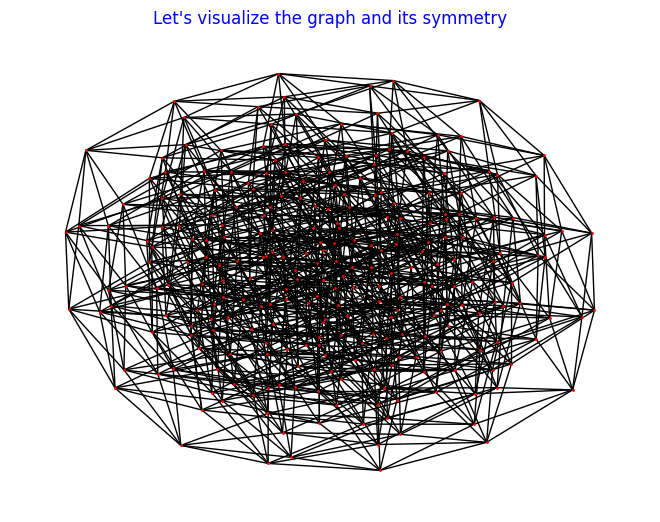

In [ ]:
import networkx as nx

# Create a new graph
graph = nx.Graph()

# Add instances of the State class as nodes to represent all 256 puzzle states
states = []
for i in range(4):
  for j in range(4):
    for k in range(4):
      for l in range(4):
        states.append(State([i,j,k,l]))
graph.add_nodes_from(states)

# Add edges to represent valid moves
for i in range(len(states)-1):
  neighbors = states[i].get_neighbors()
  for j in range(i+1, len(states)):
    for neighbor in neighbors:
      if states[j].__str__() == neighbor.__str__():
        graph.add_edge(states[i], states[j])

# Draw the grapg for a brief visualization
import matplotlib.pyplot as plt
nx.draw(graph, node_size=1, node_color='red')
plt.title("Let's visualize the graph and its symmetry", color='blue')
plt.show()

#Q1 How many different ways can we solve the puzzle?

Remember the puzzle is solved when the pictures facing each other along each side of the square match, so how many ways are there to achieve that? We could start by picking any pillar and fixing its direction in place, then the other 3 pillars should also be fixed as to make the pictures match. We could do that for each direction giving us 4 distinct goal states. With the method described, we can easily find them by hand, namely `[0,2,0,2]` , `[1,3,1,3]` , `[2,0,2,0]` , `[3,1,3,1]` and we can also confirm it by going through all the states as follows:

In [ ]:
goal_states = []
for state in states:
  pillars = state.pillars
  # Check if all 4 pairs match
  match_0_1 = (pillars[0]-1)%4 == (pillars[1]+1)%4 # Right side of pillar 0 matches with left side of pillar 1
  match_1_2 = pillars[1] == (pillars[2]+2)%4 # Lower side of pillar 1 matches with upper side of pillar 2
  match_2_3 = (pillars[2]+1)%4 == (pillars[3]-1)%4 # Left side of pillar 2 matches with right side of pillar 3
  match_3_0 = (pillars[3]+2)%4 == pillars[0] # Upper side of pillar 3 matches with lower side of pillar 0

  if match_0_1 and match_1_2 and match_2_3 and match_3_0:
    goal_states.append(state)

print("The goal states are:", [(goal.pillars) for goal in goal_states])

The goal states are: [[0, 2, 0, 2], [1, 3, 1, 3], [2, 0, 2, 0], [3, 1, 3, 1]]


# Q2 How many initial states can the puzzle have?
Let's first count the total number of states. There are 4 pillars each can be oriented in either of the 4 directions, so that's $4*4*4*4 = 256$ possible states. We can also confirm it through our created graph:

In [ ]:
print("The total number of states is ", graph.number_of_nodes())

The total number of states is  256


However we need to substract the 4 goal-states, giving us a total of 252 possible initial states.

# Q3 How many unique moves could you perform?
We need to count all the distinct direct connections between states that you could follow to transition from any state to any other. This one is not nearly as straightforward but thankfully we have our graph to count the number of connections (edges).

In [ ]:
print("The total number of connections is ", graph.number_of_edges())

The total number of connections is  1024


That gives us only half the moves, cause you can walk each edge in either direction (For every connection A-B, a valid move is going from state A to B and also going from B to A). So there are 2048 distinct moves.

# Q4 Is it always solvable no matter the initial state?

Let's have our graph answer this one as well. To show that the puzzle is solvable from any state, we can simply show that there exists a path from any node to any other i.e. a set of valid moves that takes you from any state to any other. In fact, that shows that it's solvable for any initial state and any goal state as well. In graph-theoretical terms, that property is called connectivity, so it is enough to show that our graph is connected.

In [ ]:
if nx.is_connected(graph):
  print("The graph is connected!")
else:
  print("The graph is not connected!")

The graph is connected!


# Q5 Can we come up with a strategy to always solve it?

We already know that the puzzle is always solvable but can we also prove it mathematically by finding a strategy to solve any position? It doesn't have to be an optimal strategy, just as long as it provides a step-by-step algorithm to solve any position. Here's how I approached this problem back when I wasn't even sure if the puzzle was solvable:

If we could somehow find a way to rotate any pillar in either direction while leaving the other 3 intact (let's call this single-rotation), then we could reach any state from any other by repeating this process. This approach of solving a part of the problem (in this case solving one pillar face at a time) without messing up the rest of the parts is fairly common for puzzle algorithms. Not optimal, but easy to understand and implement by humans. Another example is Rubik's cube where very often people will have one side solved and try to do the next steps without messing up the solved part.

Here's the algorithm I came up with to achieve this. First, we pick a pillar we want to single-rotate and a direction. We then rotate all 4 pillars (in any order) in the opposite direction. Finally, we rotate the pillar diagonally opposite the one we picked, also in the opposite direction. Here it is in action:

Say we want to change the 2nd pillar from 0 to 1 in the initial state. We rotate them all counter-clockwise in order. `[0,0,0,0]` -> `[3,3,0,3]` -> `[2,2,3,3]` -> `[2,1,2,2]` -> `[1,1,1,1]`. Finally we rotate the 4th pillar counter-clockwise `[1,1,1,1]` -> `[0,1,0,0]`

How does this work you ask? During the 4 rotations, each pillar is affected 3 times, one by its own rotation and 2 more from the adjacent ones. That means that by the end of the 4-move sequence, all pillars will have single-rotated 3 times no matter the order. What we'd want is a 1 time single-rotation instead of 3 but this can easily be done by reversing the direction, since in a 4 move cycle, 3 moves clockwise is the same as 1 move counter-clockwise and vice-versa. That's how we went from `[0,0,0,0]` to `[1,1,1,1]`. Now we just need one final rotation to revert 3 of the pillars back to where they started, leaving only one changed.

# Q6 How many moves would you need at most to solve any state?

This is the question that motivated me to write code for this problem since I could not figure it out mathematically. Thankfully, the problem is computationally easy enough for a computer to brute-force the answer in fractions of a second by using shortest-path algorithms in our graph.

In [ ]:
# Use the Floyd-Warshall algorithm to find all-pairs shortest paths
length = dict(nx.all_pairs_shortest_path_length(graph))
distances = []

# Loop through each starting state
for source in states:
  dist_to_goal = float('inf')

  # Loop through each goal state and find the minimum distance
  for target in goal_states:
    dist_to_goal = min(dist_to_goal, length[source][target])
  distances.append(dist_to_goal)

# Find the maximum distance among all distances
max_distance = max(distances)
print("Maximum distance:", max_distance)

Maximum distance: 4


That means that 4 moves are always enough to solve any state. The initial state `[0,0,0,0]` also happens require exactly 4 moves to solve as we can see below.

In [ ]:
print("Distance from initial state to goal is ", distances[0])

Distance from initial state to goal is  4


While we're at it, let's find all the shortest solutions from the initial state:

In [ ]:
print('Shortest paths from [0,0,0,0] to the 4 goal states: ')
for goal in goal_states:
  shortest_path = nx.shortest_path(graph, source=states[0], target=goal)
  print([s.pillars for s in shortest_path])

Shortest paths from [0,0,0,0] to the 4 goal states: 
[[0, 0, 0, 0], [1, 1, 1, 0], [0, 1, 0, 3], [1, 2, 1, 3], [0, 2, 0, 2]]
[[0, 0, 0, 0], [1, 0, 1, 1], [0, 3, 1, 0], [0, 2, 0, 3], [1, 3, 1, 3]]
[[0, 0, 0, 0], [0, 1, 1, 1], [0, 2, 2, 2], [1, 3, 2, 3], [2, 0, 2, 0]]
[[0, 0, 0, 0], [1, 1, 0, 1], [0, 0, 3, 1], [0, 1, 0, 2], [3, 1, 3, 1]]


In plain English, here are all 4 fastest ways you can solve the puzzle just as you enter the room:

1) Rotate the 1st pillar 2 times, then the 3rd pillar 2 times (any direction)

2) Rotate the 2nd pillar 2 times, then the 4th pillar 2 times (any direction)

3) Rotate the 1st and 3rd pillars clockwise, then the 2nd and 4th pillars counter-clockwise

4) Rotate the 1st and 3rd pillars counter-clockwise, then the 2nd and 4th pillars clockwise

Note that the reason any state can be solved in 4 moves or less is because at least one of the 4 goal-states has a distance of 4 or less, not all of them. In fact, if the puzzle had only one goal-state as I had mistakenly assumed at first, then it would require at most 8 moves to solve.

# Q7 Which state requires the most moves?
Since we have already computed the list with all the distances, we can just print the ones that are equal to 4. As expected, there are plenty of them.

In [ ]:
count = 0
print('These are the states that require 4 moves to solve:\n')
for i, dist in enumerate(distances):
  if dist == max_distance:
    count += 1
    print(states[i])
print("\n", count, "such states in total")

These are the states that require 4 moves to solve:

[0, 0, 0, 0]
[0, 0, 1, 1]
[0, 0, 2, 2]
[0, 0, 3, 3]
[0, 1, 1, 0]
[0, 1, 2, 3]
[0, 2, 2, 0]
[0, 3, 2, 1]
[0, 3, 3, 0]
[1, 0, 0, 1]
[1, 0, 3, 2]
[1, 1, 0, 0]
[1, 1, 1, 1]
[1, 1, 2, 2]
[1, 1, 3, 3]
[1, 2, 2, 1]
[1, 2, 3, 0]
[1, 3, 3, 1]
[2, 0, 0, 2]
[2, 1, 0, 3]
[2, 1, 1, 2]
[2, 2, 0, 0]
[2, 2, 1, 1]
[2, 2, 2, 2]
[2, 2, 3, 3]
[2, 3, 0, 1]
[2, 3, 3, 2]
[3, 0, 0, 3]
[3, 0, 1, 2]
[3, 1, 1, 3]
[3, 2, 1, 0]
[3, 2, 2, 3]
[3, 3, 0, 0]
[3, 3, 1, 1]
[3, 3, 2, 2]
[3, 3, 3, 3]

 36 such states in total


# Q8 What is the distribution of the number of moves required per state?

We can measure the frequency of each distance by counting how many times it appears in the list and present the results written and visually via a histogram.

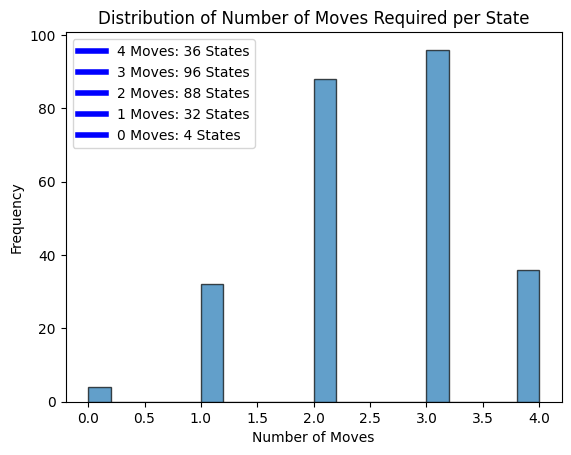

In [ ]:
# Create the histogram of distances
plt.hist(distances, bins=20, edgecolor='k', alpha=0.7, label='Number of Moves')

# Count the frequency of each move
move_counts = {}
for distance in distances:
    if distance in move_counts:
        move_counts[distance] += 1
    else:
        move_counts[distance] = 1

# Create a legend specifying the frequency of each move
legend_text = [f'{distance} Moves: {count} States' for distance, count in move_counts.items()]
plt.legend(handles=[plt.Line2D([0], [0], color='b', lw=4, label=legend) for legend in legend_text])

# Create the plot
plt.title('Distribution of Number of Moves Required per State')
plt.xlabel('Number of Moves')
plt.ylabel('Frequency')
plt.show()

# Path finder
Let's conclude the presentation with a path finder that shows you the shortest path from any state to any other! You can run the code below and enter states in the form `a,b,c,d` to try it out!

In [ ]:
# Correct input test
def valid_state(name):
  name = name.replace(" ", "")
  if name[0] != '[':
    name = '['+ name
  if name[-1] != ']':
    name += ']'

  for state in states:
    if name == state.__str__().replace(" ", ""):
      return state
  return None

# Get inputs
name = input('Type a source state: ')
while valid_state(name) is None:
  name = input('Invalid puzzle state. Try again: ')
source = valid_state(name)

name = input('Type a target state: ')
while valid_state(name) is None:
  name = input('Invalid puzzle state. Try again: ')
target = valid_state(name)

# Print the shortest path
shortest_path = nx.shortest_path(graph, source=source, target=target)
print('\n\nThe shortest path is: ', [s.pillars for s in shortest_path])